<a href="https://colab.research.google.com/github/ArthAgrawal/Audio-Forensics-Research/blob/main/Audio_Forensics_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Dataset used for this model is the ASVspoof 2017 train dataset

In [2]:
# Defining the paths in my Google Drive
audio_folder = '/content/drive/MyDrive/ASVspoof2017_V2_train/'
text_file_path = '/content/drive/MyDrive/ASVspoof2017_V2_train.trn.txt'
real_folder = '/content/drive/MyDrive/asvpoof_data/real'
fake_folder = '/content/drive/MyDrive/asvpoof_data/fake'

In [ ]:
import os
if not os.path.exists(real_folder):
    os.makedirs(real_folder)
if not os.path.exists(fake_folder):
    os.makedirs(fake_folder)

In [ ]:
with open(text_file_path, 'r') as f:
    lines = f.readlines()

for line in lines:
    # To split the line to get the filename and label
    parts = line.strip().split()
    audio_file = parts[0]  # for ex: T_1000001.wav
    label = parts[1]  # for ex: genuine or spoof

    # To define the source audio file path
    audio_path = os.path.join(audio_folder, audio_file)

    if label == 'genuine':
        target_folder = real_folder
    elif label == 'spoof':
        target_folder = fake_folder
    else:
        continue # This is to skip any unrecognized file

    os.rename(audio_path, os.path.join(target_folder, audio_file))

In [3]:
import os

num_real_files = len(os.listdir(real_folder))
num_fake_files = len(os.listdir(fake_folder))

print(f"Number of 'real' audio files: {num_real_files}")
print(f"Number of 'fake' audio files: {num_fake_files}")

Number of 'real' audio files: 1507
Number of 'fake' audio files: 1507


Till now, the datasaet has been made and separtaed into two folders: Real and Fake (each having 1507 audio samples)

In [5]:
import os
import numpy as np
import librosa            # librosa is the library used for dealing with digital audio
import librosa.display
import matplotlib.pyplot as plt

***Understanding and plotting waveforms and sampling rates***

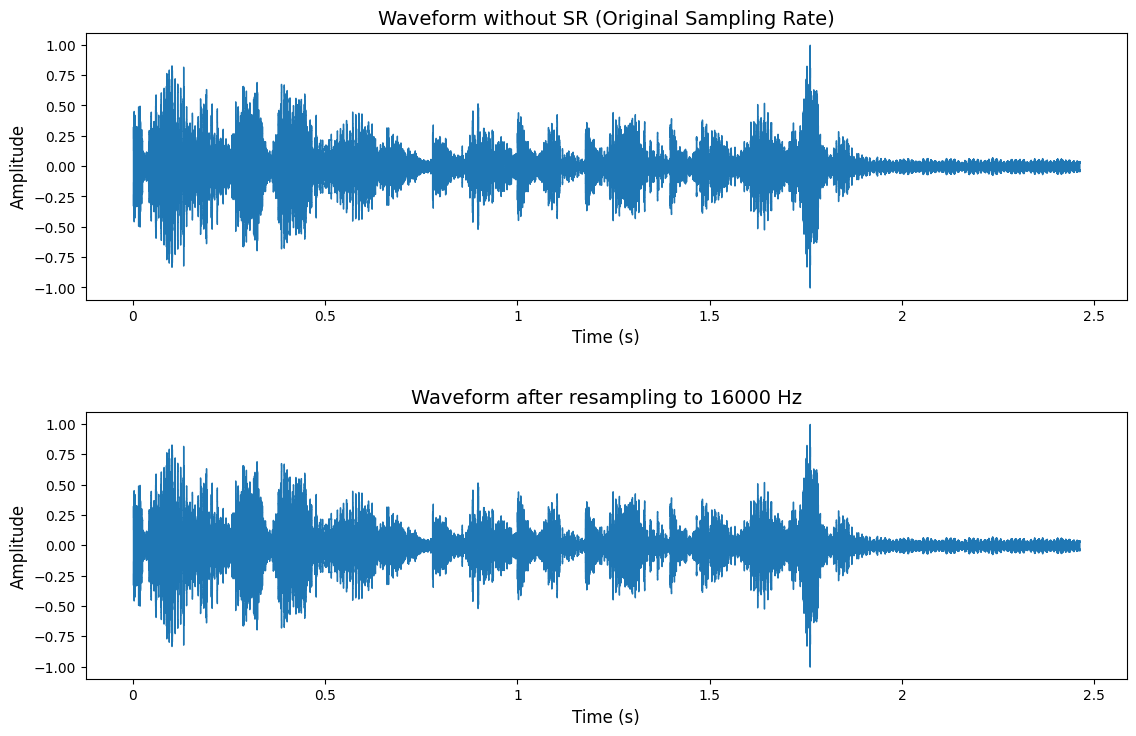

Length of y without SR (Original): 39384
Length of y with SR set to 16000: 39384
Original Sampling Rate: 16000 Hz
Exact duration of audio (without resampling): 2.46 seconds
Exact duration of audio (with resampling to 16000 Hz): 2.46 seconds


In [7]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Loading the audio file (without setting a specific sampling rate)
file_path = '/content/drive/MyDrive/asvpoof_data/fake/T_1001743.wav'  # Random audio file for testing
y_without_sr, sr_original = librosa.load(file_path, sr=None)  # sr=None to load the file at its original sampling rate

# Now visualizing the waveform after setting the sampling rate to 16kHz
sr_set = 16000
y_with_sr, sr_set_value = librosa.load(file_path, sr=sr_set)

# Plotting the waveforms
plt.figure(figsize=(12, 8))  # Adjusting the figure size for better spacing

# To plot the waveform of the original audio (without resampling)
plt.subplot(2, 1, 1)
librosa.display.waveshow(y_without_sr, sr=sr_original)
plt.title('Waveform without SR (Original Sampling Rate)', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)

# To plot the waveform of the audio after resampling to the new SR
plt.subplot(2, 1, 2)
librosa.display.waveshow(y_with_sr, sr=sr_set_value)
plt.title(f'Waveform after resampling to {sr_set} Hz', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)

# Adjust spacing
plt.tight_layout(pad=3.0)  # Adds padding between subplots
plt.show()

# Printing the lengths of the two arrays to compare
print(f"Length of y without SR (Original): {len(y_without_sr)}")
print(f"Length of y with SR set to {sr_set}: {len(y_with_sr)}")

# Printing the original sampling rate and the exact duration of the audio file in seconds
duration_without_sr = len(y_without_sr) / sr_original
duration_with_sr = len(y_with_sr) / sr_set
print(f"Original Sampling Rate: {sr_original} Hz")
print(f"Exact duration of audio (without resampling): {duration_without_sr:.2f} seconds")
print(f"Exact duration of audio (with resampling to {sr_set} Hz): {duration_with_sr:.2f} seconds")


***Just an example to understand how Mel Spectrograms can be interpreted***


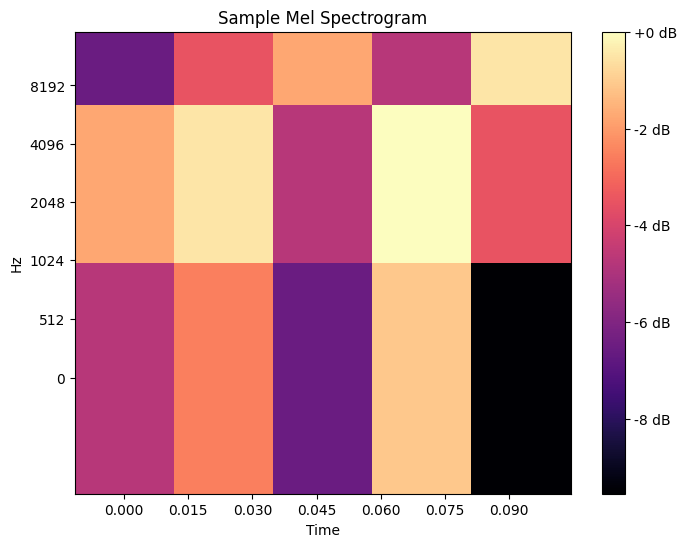

In [8]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Sample Mel spectrogram data just for visualizing
mel_spectrogram = np.array([
    [0.3, 0.5, 0.2, 0.7, 0.1],
    [0.6, 0.8, 0.3, 0.9, 0.4],
    [0.2, 0.4, 0.6, 0.3, 0.8]
])

# Plotting the Mel spectrogram
plt.figure(figsize=(8, 6))
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Sample Mel Spectrogram')
plt.show()


In [9]:
import os
import librosa
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa.display

# Converting audio to Mel spectrogram
def audio_to_mel_spectrogram(file_path, sr=16000, n_mels=128, max_time_frames=128):       # Set n_mels and max_time_frames as 128 each as CNN's usually require square input dimensions
    try:
        y, original_sr = librosa.load(file_path, sr=sr)                                   # Here, we load the 1D array of amplitudes into 'y' and the original sampling rate
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)       # Here, we convert the 1D array to a 2D array(amp vs time to freq and amp vs time) using Fast Fourier Transform
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)                # Converting to dB scale using log

        # Truncating or padding spectrogram                                                 This is to ensure all audio files are of same duration and mel spectrograms are of constant range
        if mel_spectrogram.shape[1] > max_time_frames:
            mel_spectrogram = mel_spectrogram[:, :max_time_frames]  # Truncating by removing the out of scope audio
        else:
            pad_width = max_time_frames - mel_spectrogram.shape[1]
            mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, pad_width)), mode='constant')  # Padding by adding silence till the required time frame is reached

        return mel_spectrogram
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")                              # In case of any error processing file
        return None


def load_data_from_folders(folders, labels, sr=16000, n_mels=128, max_time_frames=128):
    X, y = [], []
    for folder, label in zip(folders, labels):
        print(f"Processing {folder}...")
        for file in tqdm(os.listdir(folder)):
            file_path = os.path.join(folder, file)
            mel_spectrogram = audio_to_mel_spectrogram(file_path, sr, n_mels, max_time_frames)
            if mel_spectrogram is not None:
                X.append(mel_spectrogram)
                y.append(label)
    return np.array(X), np.array(y)


real_folder = '/content/drive/MyDrive/asvpoof_data/real'
fake_folder = '/content/drive/MyDrive/asvpoof_data/fake'
folders = [real_folder, fake_folder]
labels = [0, 1]  # Real=0, Fake=1

# Loading the data
X, y = load_data_from_folders(folders, labels)

print(f"Loaded {len(X)} samples (Real=0, Fake=1).")
print(f"Shape of feature data: {X.shape}, Shape of labels: {y.shape}")


Processing /content/drive/MyDrive/asvpoof_data/real...


100%|██████████| 1507/1507 [00:49<00:00, 30.61it/s]


Processing /content/drive/MyDrive/asvpoof_data/fake...


100%|██████████| 1507/1507 [00:45<00:00, 33.01it/s]


Loaded 3014 samples (Real=0, Fake=1).
Shape of feature data: (3014, 128, 128), Shape of labels: (3014,)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Normalizing the data
X_resized_flat = X.reshape((X.shape[0], -1))  # Flatten for normalization as MinMaxScaler requires a 2D array
scaler = MinMaxScaler()                       # Normalizing the data
X_normalized_flat = scaler.fit_transform(X_resized_flat)  # Fit and transform the data

# Reshaping back to (num_samples, 128, 128) after normalization
X_normalized = X_normalized_flat.reshape(X.shape)

# Train Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

# Step 3: Reshaping for CNN input (Adding a channel dimension) as CNN requires a 4D array as input: (num_samples, n_mels, max_time_frames, channels)
X_train = X_train[..., np.newaxis] # Channel = 1 as Mel Spectrograms are greyscale
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"Final input shape (for CNN): {X_train.shape}")


Training set shape: (2109, 128, 128), (2109,)
Validation set shape: (452, 128, 128), (452,)
Test set shape: (453, 128, 128), (453,)
Final input shape (for CNN): (2109, 128, 128, 1)


Visualising the Mel Spectrogram of a random audio

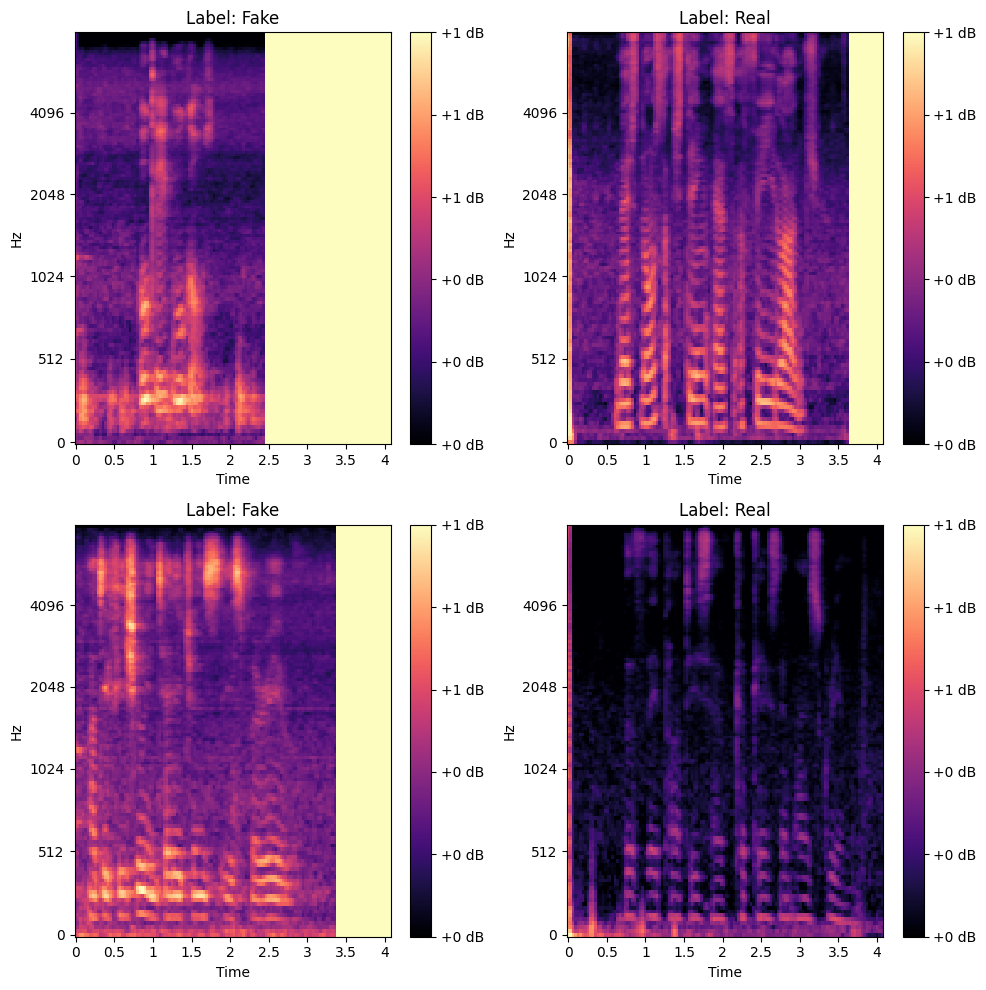

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

def plot_mel_spectrograms(X, y, sr=16000, num_samples=4):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X))  # Random index
        mel_spectrogram = X[idx, :, :, 0]   # Remove the channel dimension for visualization
        label = "Real" if y[idx] == 0 else "Fake"

        plt.subplot(2, 2, i+1)
        # Display mel spectrogram with time and mel frequency axes
        librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=sr)
        plt.title(f"Label: {label}")
        plt.colorbar(format="%+2.0f dB")
        plt.axis('on')

    plt.tight_layout()
    plt.show()

# Visualize a few Mel spectrograms from the training set
plot_mel_spectrograms(X_train, y_train, num_samples=4)


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(input_shape):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),

        # Convolutional layers with batch normalization and LeakyReLU
        layers.Conv2D(32, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),

        # Fully connected layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(1, activation='sigmoid')  # Sigmoid as it is a binary classification
    ])

    return model

model = build_model((128, 128, 1))  # Input shape is 128x128 with 1 channel (grayscale)

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │              

 Total params: 430,977 (1.64 MB)

 Trainable params: 430,017 (1.64 MB)

 Non-trainable params: 960 (3.75 KB)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,   # Reduce learning rate by half
                              patience=6,   # Wait for 2 epochs before reducing the learning rate
                              min_lr=1e-6,   # Minimum learning rate
                              verbose=1)

history = model.fit(X_train, y_train,
                    epochs=40,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.9947 - loss: 0.0240 - val_accuracy: 0.9581 - val_loss: 0.1000 - learning_rate: 0.0010
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9940 - loss: 0.0201 - val_accuracy: 0.5011 - val_loss: 16.7197 - learning_rate: 0.0010
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9964 - loss: 0.0121 - val_accuracy: 0.8234 - val_loss: 0.5651 - learning_rate: 0.0010
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9983 - loss: 0.0063 - val_accuracy: 0.9890 - val_loss: 0.0516 - learning_rate: 0.0010
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9956 - loss: 0.0154 - val_accuracy: 0.9581 - val_loss: 0.1638 - learning_rate: 0.0010
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9973 - loss: 0.0211 - val_accuracy: 0.9978 - val_loss: 0.0150 - learning_rate: 0.0010
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9989 - loss: 0.0027 - val_a

In [19]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Final Accuracy of the model: {test_accuracy * 100:.2f}%")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0013    
Test Loss: 0.0028, Test Accuracy: 0.9978
Final Accuracy of the model: 99.78%


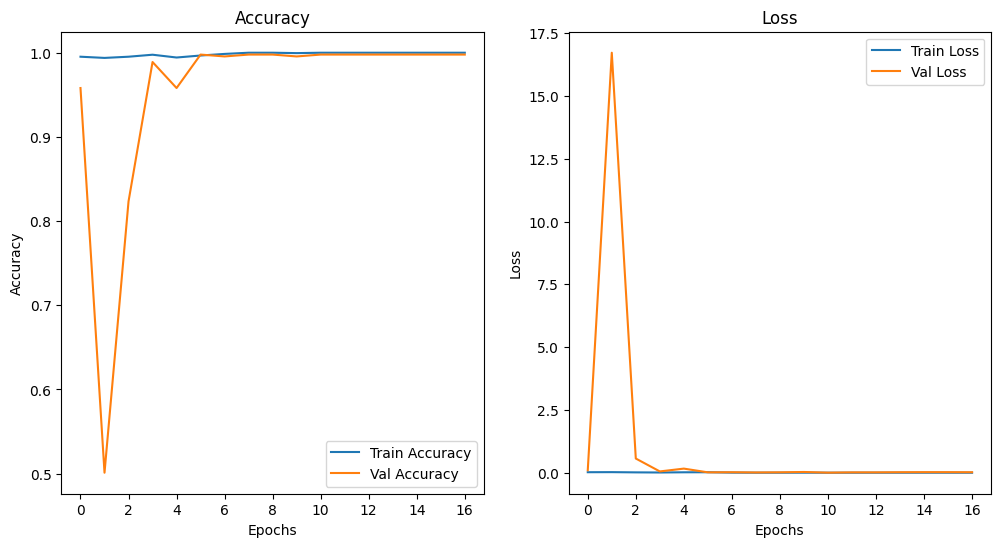

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       227
           1       1.00      1.00      1.00       226

    accuracy                           1.00       453
   macro avg       1.00      1.00      1.00       453
weighted avg       1.00      1.00      1.00       453



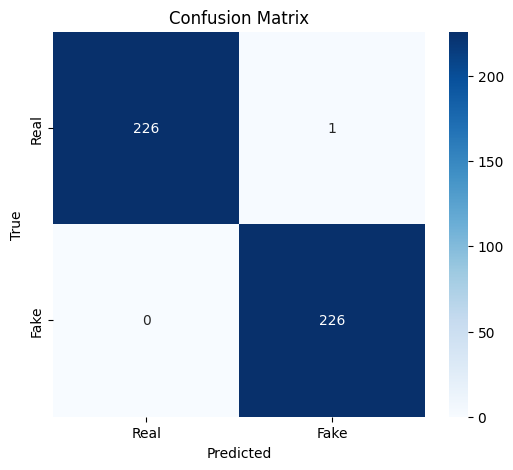

ROC-AUC Score: 0.9978


In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels (0 or 1)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC Score: {roc_auc:.4f}")


In [22]:
# Saving the model in H5 format
model.save('/content/drive/MyDrive/Audio_Forensics_Models/asvpoof_model.h5')
print("Model saved to '/content/drive/MyDrive/asvpoof_model.h5'")

Model saved to '/content/drive/MyDrive/asvpoof_model.h5'


Now to test the model on actual audios both from dataset and audio samples we input

In [23]:
import librosa
import numpy as np
import cv2
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/Audio_Forensics_Models/asvpoof_model.h5')

def audio_to_mel_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

def predict_audio(file_path):
    mel_spectrogram = audio_to_mel_spectrogram(file_path)
    mel_resized = librosa.util.fix_length(mel_spectrogram, size=128, axis=1)
    mel_resized = cv2.resize(mel_resized, (128, 128))  # Resize to 128x128
    mel_resized = mel_resized.reshape(1, 128, 128, 1)  # Shape should be (1, 128, 128, 1)
    prediction = model.predict(mel_resized)
    predicted_class = 'Fake' if prediction > 0.5 else 'Real'
    return predicted_class

new_file = '/content/drive/MyDrive/asvpoof_data/fake/T_1002541.wav'
prediction = predict_audio(new_file)
print(f"Prediction for {new_file}: {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
Prediction for /content/drive/MyDrive/asvpoof_data/fake/T_1002541.wav: Fake


In [24]:
import librosa
import numpy as np
import cv2
import tensorflow as tf
from google.colab import files

model = tf.keras.models.load_model('/content/drive/MyDrive/Audio_Forensics_Models/asvpoof_model.h5')

def audio_to_mel_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

def predict_audio(file_path):
    mel_spectrogram = audio_to_mel_spectrogram(file_path)
    mel_resized = librosa.util.fix_length(mel_spectrogram, size=128, axis=1)
    mel_resized = cv2.resize(mel_resized, (128, 128))
    mel_resized = mel_resized.reshape(1, 128, 128, 1)
    prediction = model.predict(mel_resized)
    predicted_class = 'Fake' if prediction > 0.5 else 'Real'
    return predicted_class

uploaded = files.upload()
new_file = next(iter(uploaded))

prediction = predict_audio(new_file)
print(f"Prediction for {new_file}: {prediction}")


Saving file10025.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav to file10025.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
Prediction for file10025.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav: Real
